In [1]:
pip install -q datasets


     |████████████████████████████████| 325 kB 7.2 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 61.9 MB/s 
     |████████████████████████████████| 136 kB 72.7 MB/s 
     |████████████████████████████████| 212 kB 71.8 MB/s 
     |████████████████████████████████| 127 kB 63.7 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 64.2 MB/s 
     |████████████████████████████████| 144 kB 65.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
pip install -q transformers

     |████████████████████████████████| 4.0 MB 9.1 MB/s 
     |████████████████████████████████| 6.5 MB 45.6 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 895 kB 64.0 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.figure_factory as ff
from transformers import TFAutoModel
from transformers import TrainingArguments


In [5]:
# https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': 'NLP_train.csv', 'test': 'NLP_test.csv'}, encoding = "ISO-8859-1")


Using custom data configuration default-fde4a662a8b4480e


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fde4a662a8b4480e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
type(dataset)
dataset['train'][5]

{'fixed_text': 'people who will cure lyme disease are the patients themselves sign up today mylymedata',
 'id': 785631171531112449,
 'keywords_label': 1,
 'text': 'People who will cure #Lyme disease are the patients themselves! Sign up today! #MyLymeData https://t.co/QpxHri4Uak https://t.co/HGZTMHz6bs'}

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'keywords_label', 'fixed_text'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['id', 'text', 'keywords_label', 'fixed_text'],
        num_rows: 7500
    })
})

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")



Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
tokenizer("hello my world")

{'input_ids': [0, 2279, 23, 220, 2], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [10]:
def transform_labels(label):

    num = label['keywords_label']
    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['fixed_text'], padding='max_length')

dataset = dataset.map(tokenize_data, batched=True)

remove_columns = ['id','text','keywords_label','fixed_text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/70000 [00:00<?, ?ex/s]

  0%|          | 0/7500 [00:00<?, ?ex/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
})

In [12]:

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base")


Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [13]:
# Shuffle data and make train dataset with 60,000 tweets and evaluation dataset with 10,000 tweets
temp_ds = dataset['train'].shuffle(seed=111)
train_dataset = temp_ds.select(range(60000))
eval_dataset = temp_ds.select(range(60000, 70000))


In [14]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 60000
})

In [15]:
eval_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [16]:
dataset['train']

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 70000
})

In [17]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [18]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 60000
})

In [19]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [20]:
batch_size=64
epochs=2
training_args = TrainingArguments("test_trainer", num_train_epochs=epochs, 
                  learning_rate=2e-5, per_device_train_batch_size=batch_size, 
                  per_device_eval_batch_size=batch_size, weight_decay=0.01,
                  evaluation_strategy="epoch")

In [21]:
from sklearn.metrics import classification_report, precision_score, \
    recall_score, f1_score, accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [22]:

trainer = Trainer(
    model=model, args=training_args, compute_metrics=compute_metrics,
    train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer=tokenizer
)
trainer.train()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 60000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1876


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.204800,0.116210,0.965100,0.964886,0.977375,0.952712
2,0.091800,0.103593,0.969100,0.968829,0.984016,0.954103


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-500/special_tokens_map.json
added tokens file saved in test_trainer/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 64
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1000/special_tokens_map.json
added tokens file saved in test_trainer/checkpoint-1000/added_tokens.json
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in

TrainOutput(global_step=1876, training_loss=0.12678362921611078, metrics={'train_runtime': 2542.2234, 'train_samples_per_second': 47.203, 'train_steps_per_second': 0.738, 'total_flos': 7893331660800000.0, 'train_loss': 0.12678362921611078, 'epoch': 2.0})

In [23]:
pred_output = trainer.predict(eval_dataset)
pred_output.metrics

***** Running Prediction *****
  Num examples = 10000
  Batch size = 64


{'test_accuracy': 0.9691,
 'test_f1': 0.9688288106526782,
 'test_loss': 0.1035933718085289,
 'test_precision': 0.9840163934426229,
 'test_recall': 0.9541029207232267,
 'test_runtime': 69.4876,
 'test_samples_per_second': 143.911,
 'test_steps_per_second': 2.259}

In [24]:
test_dataset = dataset['test']
pred_output_test = trainer.predict(test_dataset)
pred_output_test.metrics

***** Running Prediction *****
  Num examples = 7500
  Batch size = 64


{'test_accuracy': 0.8992,
 'test_f1': 0.8961253091508656,
 'test_loss': 0.3672192692756653,
 'test_precision': 0.9373383156079333,
 'test_recall': 0.8583837852066333,
 'test_runtime': 51.9048,
 'test_samples_per_second': 144.495,
 'test_steps_per_second': 2.273}

In [27]:
y_preds = np.argmax(pred_output_test.predictions, axis=1)


In [30]:
# Adopted from O'Reilly Natural Language Processing with Transformers book
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_cm(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize= "true")
  flg, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax = ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()




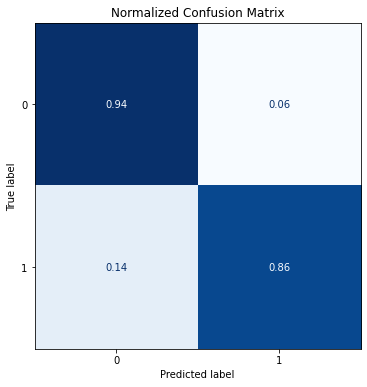

In [31]:

plot_cm(y_preds, test_dataset['labels'], test_dataset['labels'])